<a href="https://colab.research.google.com/github/MtTake/PINNs/blob/main/2D_Navier_Eq_LatShp_Lodr_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 弾性力学の支配方程式

- つり合い式 \\
- 適合条件式(変位-ひずみ関係式)
- 構成式(応力-ひずみ関係式) \\

### 1. つり合い式
　二次元で考えると、

$$
\frac{\partial \sigma_x}{\partial x} + \frac{\partial \tau_{xy}}{\partial y} + X = 0 \\
\frac{\partial \sigma_y}{\partial y} + \frac{\partial \tau_{xy}}{\partial x} + Y = 0 \\
 $$

### 2. 適合条件式

$$
\frac{\partial^2 \epsilon_x}{\partial y^2} + \frac{\partial^2 \epsilon_y}{\partial x^2} = \frac{\partial^2 \gamma_{xy}}{\partial x \partial y} \\
\epsilon_x = \frac{\partial u}{\partial x}, \quad
\epsilon_y = \frac{\partial v}{\partial y}, \quad
\gamma_{xy} = \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x}
$$

### 3. 構成式

$$
\begin {Bmatrix}
       \epsilon_x \\
       \epsilon_y \\
       \epsilon_z \\
       \gamma_{xy} \\
       \gamma_{yz} \\
       \gamma_{zx}
\end {Bmatrix}
= \frac{1}{E}
\begin {bmatrix}
       1 & -\nu & -\nu & 0 & 0 & 0 \\
       -\nu & 1 & -\nu & 0 & 0 & 0 \\
       -\nu & -\nu & 1 & 0 & 0 & 0 \\
       0 & 0 & 0 & 2(1+\nu) & 0 & 0\\
       0 & 0 & 0 & 0 & 2(1+\nu) & 0 \\
       0 & 0 & 0 & 0 & 0 & 2(1+\nu)
\end {bmatrix}
\begin {Bmatrix}
       \sigma_x \\
       \sigma_y \\
       \sigma_z \\
       \tau_{xy} \\
       \tau_{yz} \\
       \tau_{zx}
\end {Bmatrix}
$$

# Navier の方程式

$$
G \left(\nabla^2u_i + \frac{1}{1-2\nu}\frac{\partial \epsilon_i}{\partial x_i}
 \right) + X_i = \rho \frac{\partial^2 u_i}{\partial t^2} \quad (i=1,2,3) \\
E=2G(1+\nu)
$$

$E$ : ヤング率($206GPa$)、$G$ :せん断弾性係数($79GPa$)、$\nu$ :ポアソン比($0.3$)、括弧内は鉄の場合．


静的釣合い条件では、時間微分の項はゼロとなり、$i$ を $x,y,z$ で書くと、

$$
G \left( \nabla^2u_x + \frac{1}{1-2\nu}\frac{\partial \epsilon_x}{\partial x}  \right) + F_x = 0 \\
G \left( \nabla^2u_y + \frac{1}{1-2\nu}\frac{\partial \epsilon_y}{\partial y} \right) + F_y = 0 \\
G \left( \nabla^2u_z + \frac{1}{1-2\nu}\frac{\partial \epsilon_y}{\partial z} \right) + F_z = 0
$$


# 損失関数

損失関数は、ニューラルネットワークの出力が連続体方程式を満たすようにする．具体的には、以下のような損失関数を定義：

$$ L_{\text{total}} = L_{\text{PDE}} + L_{\text{BC}} + L_{\text{IC}}. $$

- **PDE損失項** $L_{\text{PDE}}$：ネットワークの出力がPDEを満たすようにする損失．具体的には、次の手順で計算：

  1. ネットワークの出力 $u$、$\epsilon$、$X$ から、PDEに必要な偏微分を計算．
  2. PDEの左辺 $\mathcal{L}$ を計算し、その結果がゼロに近くなるようにする．
  3. 損失として、PDEの残差（$\mathcal{L}(u(x,t))$）の二乗和を使用．

$$
L_{\text{PDE}} = \frac{1}{3N_{\text{PDE}}} \sum_{j=1}^{N_{\text{PDE}}}  \sum_{i}^{x,y,z} \left( G \left(\nabla^2u_{ij} + \frac{1}{1-2\nu}\frac{\partial \epsilon_{ij}}{\partial x_{ij}} \right)
 + X_{ij} \right)^2
$$

- **境界条件損失項** $L_{\text{BC}}$：境界条件を満たすようにする損失

  例えば、$x = 0$ と $x = L$ での境界条件が $u_{BC}(0) = u_L$ と $u_{BC}(L) = u_R$ である場合、次のように計算：

$$
\begin{align}
L_{\text{BC}} &= \frac{1}{N_{\text{BC}}} \sum_{j=1}^{N_{\text{BC}}} \left(u(x_j) - u_{\text{BC}}(x_j) \right)^2 \\
&= \frac{1}{2} \sum_{j=1}^{N_{\text{BC}}} \{ \left( u(x_j=0) - u_{\text{BC}}(x_j=0)\right) + \left( u(x_j=L) - u_{\text{BC}}(x_j=L) \right) \} \\
&= \frac{1}{2} \sum_{j=1}^{N_{\text{BC}}} \{ \left( u(x_j=0) - u_{\text{L}}\right) + \left( u(x_j=L) - u_{\text{R}} \right) \} \\
\end{align}
$$

- **初期条件損失項** $L_{\text{IC}}$：初期条件（例えば、$x=0$ のときの $F_x$ の値）を満たすようにする損失．初期条件損失は次のように書ける：

  $$ L_{\text{IC}} = \frac{1}{N_{\text{IC}}} \sum_{k=1}^{N_{\text{IC}}} \left(F_x(x_k) - F_{x\text{IC}}(x_k) \right)^2, $$

  ここで、$u_{\text{IC}}$ は初期条件に従った値．

# 学習

PINNsのトレーニングは、損失関数 $L_{\text{total}}$ を最小化する．ネットワークの出力がPDE、境界条件、初期条件を満たすように重みが調整される．


### 1. ライブラリ インポート

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(111)

In [2]:
# GPUが利用可能か確認
if torch.cuda.is_available():
    free_total = 0
    for i in range(torch.cuda.device_count()):

        # GPUメモリの情報を取得
        total_memory = torch.cuda.get_device_properties(i).total_memory
        reserved_memory = torch.cuda.memory_reserved(i)
        allocated_memory = torch.cuda.memory_allocated(i)
        free_memory = total_memory - reserved_memory
        free_total += free_memory

        print(f"GPU memory {i}: {total_memory / (1024 **3):.2f} GB")
        print(f"Reserved memory: {reserved_memory / (1024 **3):.2f} GB")
        print(f"Allocated memory: {allocated_memory / (1024 **3):.2f} GB")
        print(f"Free memory: {free_memory / (1024 **3):.2f} GB")
        print('------------------------------')

    print(f"Free Total memory : {free_total / (1024 **3):.2f} GB")

else:
    print("CUDA is not available")

CUDA is not available


In [3]:
num_points = 100
# num_points = 20

N = 1            # 異なるデータセットの数
# batch_size = 200    # バッチサイズ
# N = 2               # 異なるデータセットの数
batch_size = 1000      # バッチサイズ

size = 1     # [m]　平板サイズ
Fphy = 1     # [N]　入力荷重

n_in_out = 2
n_make_out = 6

# 物理定数
# E = 206 * 10^9 # [Pa] ヤング率
# G = 79 * 10^9  # [Pa] せん断弾性係数
# nu = 0.3       #      ポアソン比
E = 1          # [Pa] ヤング率
nu = 0.3       #      ポアソン比
G = E / (2*(1+nu))          # [Pa] せん断弾性係数

size = 1     # [m]　平板サイズ
Fphy = 1     # [N]　入力荷重

L = 1.0  # 正規化空間範囲
FX = 1.0  # 正規化荷重
# N_bc = 100
# N_ic = 1
N_bc = 100
N_ic = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# カスタムデータセットの定義
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
# 訓練データの生成
def generate_data(num_points):
    # x と t の範囲を設定
    x_plot = torch.linspace(-L, L, num_points).reshape(-1, 1) # [100, 1]
    y_plot = torch.linspace(-L, L, num_points).reshape(-1, 1) # [100, 1]

    # メッシュグリッドを作成
    # X_g は x_plot の値を列方向に繰り返した行列
    # Y_g は y_plot の値を行方向に繰り返した行列
    # X_g=[100, 100],Y_g=[100, 100]
    X_g, Y_g = torch.meshgrid(x_plot.squeeze(), y_plot.squeeze(), indexing='ij')

    # Flatten 行優先で1行目のあとに2行目を並べる
    # cat dim=1 で全組み合わせ (n,2)
    X_flat = X_g.reshape(-1, 1) # [10000, 1]
    Y_flat = Y_g.reshape(-1, 1) # [10000, 1]

    # gen_data = torch.rand(num_points, 2) * 2 - 1  # [-1, 1]の範囲でサンプルを生成
    gen_data = torch.cat((X_flat, Y_flat), dim=1)       # [10000, 2]

    # # 初期条件　⇒　0:2
    # init_cond = torch.tensor([[0,0]])
    # gen_data = torch.cat((init_cond, gen_data))  # # [10001, 2]

    return gen_data

In [6]:
# 学習用のサンプルデータの生成
all_data = [generate_data(num_points) for _ in range(N)]

# データを結合し、[N, 20000]の形状に変換
combined_data = torch.cat(all_data)  # [20000, 2]
print('combined data = ', combined_data.shape)

# カスタムデータセットを作成
dataset = CustomDataset(combined_data)

# DataLoaderの作成
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

combined data =  torch.Size([10000, 2])


### 3. ネットワークモデルの定義

In [7]:
# ニューラルネットワークの定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(n_in_out, 32)
        self.fc2 = nn.Linear(32, 64)
        # self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, n_make_out)
        self.fc6 = nn.Sigmoid()
        self.apply(self.init_weights) # 重み初期化を適用

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)  # Xavier初期化
            if m.bias is not None:
                init.zeros_(m.bias)  # バイアスはゼロ初期化

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        # x = F.leaky_relu(self.bn2(self.fc2(x)), negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc5(x), negative_slope=0.01)
        x = self.fc6(x)
        return x

### 4. Loss関数の定義

In [8]:
# Navier方程式の計算
def derivatives(u, e, x):
    u_x = torch.autograd.grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(outputs=u_x, inputs=x, grad_outputs=torch.ones_like(u_x),
                               create_graph=True, retain_graph=True)[0]
    # u_xx = torch.autograd.grad(outputs=u_x[:, 0], inputs=x, grad_outputs=torch.ones_like(u_x[:, 0]),
    #                            create_graph=True, retain_graph=True)[0][:, 0]
    # u_yy = torch.autograd.grad(outputs=u_x[:, 1], inputs=x, grad_outputs=torch.ones_like(u_x[:, 1]),
    #                            create_graph=True, retain_graph=True)[0][:, 1]
    u_e = torch.autograd.grad(outputs=e, inputs=x, grad_outputs=torch.ones_like(e),
                              create_graph=True, retain_graph=True)[0]

    return u_xx, u_e

In [9]:
# 損失関数の定義
def loss_function(u_bc):

    u_bc = u_bc.to(device)
    f_ic = f_ic.to(device)

    # 境界条件損失
    ux_bc_pred = u_bc[:, 0]                          # 変位を抽出
    uy_bc_pred = u_bc[:, 1]                          # 変位を抽出
    loss_bc = torch.mean(ux_bc_pred**2) + torch.mean(uy_bc_pred)**2

    # 初期条件損失
    fx_ic_pred = u_bc[:, 4]                         # 荷重を抽出
    fy_ic_pred = u_bc[:, 5]                         # 荷重を抽出

    ic_pred_xy_n = f_pred_xy[:, :2]
    ini_len = f_pred_xy.shape[0]                      # 0次元の長さ:n
    init_cond = torch.ones((ini_len, 2)).to(device)   # [n,2]の配列
    loss_ic = torch.mean((ic_pred_xy_n - init_cond)**2)

    loss_ic = 0.5 * (torch.mean((fx_ic_pred - f_ic[:,0])**2) + torch.mean((fy_ic_pred - f_ic[:,1])**2))

    # print('fx_ic_pred=', fx_ic_pred)
    # print('fy_ic_pred=', fy_ic_pred)
    # print('loss_ic=', loss_ic)
    # print('loss_bc=', loss_bc)

    return loss_bc, loss_ic

### 5. モデルの学習

In [10]:
# ハイパーパラメータ
# num_epochs = 10000
# num_epochs = 50000
num_epochs = 5000
learning_rate = 0.0001
# learning_rate = 0.001

# モデルの初期化
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# ***** test *******************************************************************
cnt_t = 0
model.eval().to(device)

for x_t in data_loader:
    x_t = x_t.to(device)
    x_t.requires_grad = True                 # 勾配計算を可能にする

    # 境界条件を入力バッチ方向へ追加
    x_bc_t = torch.cat((torch.full((N_bc, 1), -L), torch.full((N_bc, 1), L)), dim=0) # x=-1,x=1の位置の配列
    y_bc_t = torch.rand((2 * N_bc, 1)) * L                # y座標はランダム
    bc_x_t = torch.cat((x_bc_t, y_bc_t), dim=1).to(device)    #
    x_t = torch.cat((bc_x_t, x_t), dim=0)                     # バッチ方向へ追加

    # 入力条件を入力バッチ方向へ追加
    ic_x_t = torch.tensor([[0, 0]], dtype=torch.float32).to(device)  # 荷重点を設定
    x_t = torch.cat((ic_x_t, x_t), dim=0)                     # バッチ方向へ追加

    # モデルの出力を計算
    u_t = model(x_t)  # [batch_size=N * 10000, 2] ⇒ [batch_size=N * 10000, 6]

    # 配列を2次元に分離
    re_ux_t = u_t[:, :2]
    re_ex_t = u_t[:, 2:4]
    re_fx_t = u_t[:, 4:6]

    # Navier方程式計算
    u_x_t = torch.autograd.grad(outputs=re_ux_t, inputs=x_t, grad_outputs=torch.ones_like(re_ux_t),
                              create_graph=True, retain_graph=True)[0]
    u_xx_t = torch.autograd.grad(outputs=u_x_t, inputs=x_t, grad_outputs=torch.ones_like(u_x_t),
                                create_graph=True, retain_graph=True)[0]
    u_e_t = torch.autograd.grad(outputs=re_ex_t, inputs=x_t, grad_outputs=torch.ones_like(re_ex_t),
                              create_graph=True, retain_graph=True)[0]

    # u_xx_t = u_xx_t.reshape(-1, 2)
    # u_e_t = u_e_t.reshape(-1, 2)
    # u_f_t = re_fx_t.reshape(-1, 2)

    # 境界条件の損失
    loss_bc_t = torch.mean(re_ux_t[1:2 * N_bc + 1, :]**2)

    # 入力条件の損失
    f_ic_t = torch.tensor([[1, 1]], dtype=torch.float32).to(device)                             # 荷重を入れる
    loss_ic_t = torch.mean((f_ic_t - re_fx_t[0, :])**2)



print('*** Input ***')
print(bc_x_t.shape)
print("bc_x_t=", bc_x_t)
print(ic_x_t.shape)
print("ic_x_t=", ic_x_t)
print(x_t.shape)
print('x_t=',x_t[:50])

print('*** Output ***')
print(re_ux_t.shape)
print('re_ux_t=',re_ux_t[:5])
print(re_ex_t.shape)
print('re_ex_t=',re_ex_t[:5])
print(re_fx_t.shape)
print('re_fx_t=',re_fx_t[:5])

print('*** Derivatives ***')
print(u_x_t.shape)
print('u_x=',u_x_t[:5])
print(u_xx_t.shape)
print('u_xx=',u_xx_t[:5])
print(u_e_t.shape)
print('u_e=',u_e_t[:5])
print('u_e.sum=', u_e_t.sum(dim=1)[:5])
print('Navier =', G * (size**2 * (u_xx_t.sum(dim=1)) + 1/(1-2*nu)*(u_e_t.sum(dim=1))) + Fphy * (re_fx_t.sum(dim=1)))

print('*** Boundary Loss ***')
print(re_ux_t[1:2 * N_bc + 1, :])

print('*** Initial Loss ***')
print(re_fx_t[0, :])


*** Input ***
torch.Size([200, 2])
bc_x_t= tensor([[-1.0000,  0.9151],
        [-1.0000,  0.5896],
        [-1.0000,  0.7490],
        [-1.0000,  0.0773],
        [-1.0000,  0.9018],
        [-1.0000,  0.7451],
        [-1.0000,  0.3513],
        [-1.0000,  0.1743],
        [-1.0000,  0.6253],
        [-1.0000,  0.8070],
        [-1.0000,  0.6963],
        [-1.0000,  0.2455],
        [-1.0000,  0.3398],
        [-1.0000,  0.9754],
        [-1.0000,  0.3470],
        [-1.0000,  0.1774],
        [-1.0000,  0.7936],
        [-1.0000,  0.4842],
        [-1.0000,  0.4830],
        [-1.0000,  0.1464],
        [-1.0000,  0.0619],
        [-1.0000,  0.8272],
        [-1.0000,  0.0827],
        [-1.0000,  0.1276],
        [-1.0000,  0.3383],
        [-1.0000,  0.1043],
        [-1.0000,  0.1161],
        [-1.0000,  0.1171],
        [-1.0000,  0.5619],
        [-1.0000,  0.2690],
        [-1.0000,  0.2190],
        [-1.0000,  0.1738],
        [-1.0000,  0.0951],
        [-1.0000,  0.7865],
     

In [12]:
total_error_record = []
nav_error_record = []
bc_error_record = []
ic_error_record = []

# 訓練ループ
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    loss_total = 0

    for x in data_loader:
        x = x.to(device)
        x.requires_grad = True                 # 勾配計算を可能にする

        # 境界条件を入力バッチ方向へ追加
        x_bc = torch.cat((torch.full((N_bc, 1), -L), torch.full((N_bc, 1), L)), dim=0) # x=-1,x=1の位置の配列
        y_bc = torch.rand((2 * N_bc, 1)) * L                # y座標はランダム
        bc_x = torch.cat((x_bc, y_bc), dim=1).to(device)    #
        x = torch.cat((bc_x, x), dim=0)                     # バッチ方向へ追加

        # 入力条件を入力バッチ方向へ追加
        ic_x = torch.tensor([[0, 0]], dtype=torch.float32).to(device)  # 荷重点を設定
        x = torch.cat((ic_x, x), dim=0)                     # バッチ方向へ追加

        # **********************
        # モデルの出力を計算
        u = model(x)
        # **********************

        # デコーダからの出力を3次元の座標情報、変位情報と荷重情報に分ける
        re_ux = u[:, :2]                 # 配列を2次元に分離
        re_ex = u[:, 2:4]
        re_fx = u[:, 4:6]

        # Navierの残差を計算
        u_xx, u_e = derivatives(re_ux, re_ex, x)
        derivatives_residual = G * (size**2 * (u_xx.sum(dim=1)) + 1/(1-2*nu)*(u_e.sum(dim=1))) + Fphy * (re_fx.sum(dim=1))

        loss_nav = torch.mean(derivatives_residual**2)        # 損失を計算

        # 境界条件の損失
        loss_bc = torch.mean(re_ux[1:2 * N_bc + 1, :]**2)

        # 入力条件の損失
        f_ic = torch.tensor([[1, 1]], dtype=torch.float32).to(device)                             # 荷重を入れる
        loss_ic = torch.mean((f_ic - re_fx[0, :])**2)

        loss = loss_nav + loss_bc + loss_ic

        # 逆伝播と最適化
        loss.backward()
        optimizer.step()

    loss_nav_rec = loss_nav.item()
    loss_bc_rec = loss_bc.item()
    loss_ic_rec = loss_ic.item()
    loss_total = loss.item()
    nav_error_record.append(loss_nav_rec)
    bc_error_record.append(loss_bc_rec)
    ic_error_record.append(loss_ic_rec)
    total_error_record.append(loss_total)


    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Total Loss: {loss.item()}, Navier Loss: {loss_nav.item()}, IC Loss: {loss_ic.item()}, BC Loss: {loss_bc.item()}')

Epoch 0, Total Loss: 1.428808569908142, Navier Loss: 0.9287768006324768, IC Loss: 0.25000953674316406, BC Loss: 0.2500222325325012
Epoch 100, Total Loss: 1.1091632843017578, Navier Loss: 0.6304934024810791, IC Loss: 0.2668754458427429, BC Loss: 0.21179451048374176
Epoch 200, Total Loss: 0.3995663523674011, Navier Loss: 0.10191996395587921, IC Loss: 0.2558029294013977, BC Loss: 0.04184344410896301
Epoch 300, Total Loss: 0.29450687766075134, Navier Loss: 0.057279206812381744, IC Loss: 0.22709417343139648, BC Loss: 0.010133497416973114
Epoch 400, Total Loss: 0.6519618034362793, Navier Loss: 0.39986172318458557, IC Loss: 0.057787954807281494, BC Loss: 0.19431211054325104
Epoch 500, Total Loss: 0.5047321319580078, Navier Loss: 0.3120483458042145, IC Loss: 0.021996118128299713, BC Loss: 0.17068763077259064
Epoch 600, Total Loss: 0.37051859498023987, Navier Loss: 0.22188301384449005, IC Loss: 0.012587101198732853, BC Loss: 0.13604849576950073
Epoch 700, Total Loss: 0.2997403144836426, Navier 

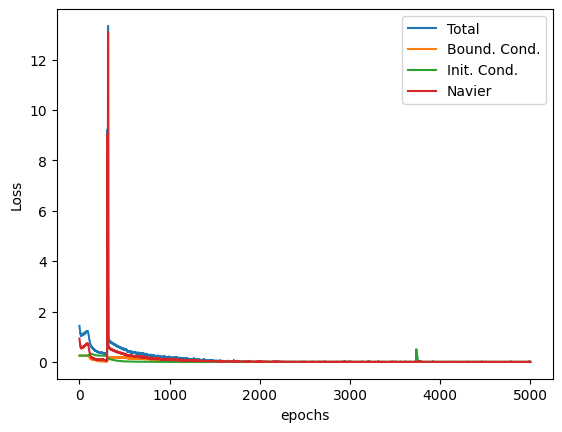

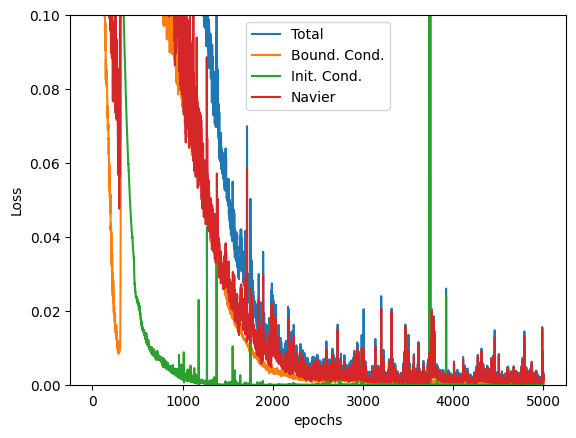

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(total_error_record)+1),total_error_record,label="Total")
plt.plot(range(1, len(bc_error_record)+1),bc_error_record,label="Bound. Cond.")
plt.plot(range(1, len(ic_error_record)+1),ic_error_record,label="Init. Cond.")
plt.plot(range(1, len(nav_error_record)+1),nav_error_record,label="Navier")
plt.legend()

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

# y軸の範囲を指定
plt.plot(range(1, len(total_error_record)+1),total_error_record,label="Total")
plt.plot(range(1, len(bc_error_record)+1),bc_error_record,label="Bound. Cond.")
plt.plot(range(1, len(ic_error_record)+1),ic_error_record,label="Init. Cond.")
plt.plot(range(1, len(nav_error_record)+1),nav_error_record,label="Navier")
plt.legend()

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.1) # 最小値と最大値を指定
plt.show()

In [14]:
# 境界条件と初期条件のサンプル
model.eval().to(device)

# 境界条件を入力バッチ方向へ追加
x_bc = torch.cat((torch.full((N_bc, 1), -L), torch.full((N_bc, 1), L)), dim=0) # x=-1,x=1の位置の配列
y_bc = torch.rand((2 * N_bc, 1)) * L                # y座標はランダム
bc_x = torch.cat((x_bc, y_bc), dim=1).to(device)    #

# 入力条件を入力バッチ方向へ追加
ic_x = torch.tensor([[0, 0]], dtype=torch.float32).to(device)  # 荷重点を設定
x = torch.cat((ic_x, bc_x), dim=0)                     # バッチ方向へ追加

# **********************
# モデルの出力を計算
u = model(x)
# **********************

# デコーダからの出力を3次元の座標情報、変位情報と荷重情報に分ける
re_ux = u[:, :2]                 # 配列を2次元に分離
re_ex = u[:, 2:4]
re_fx = u[:, 4:6]

# 境界条件の損失
loss_bc = torch.mean(re_ux[1:2 * N_bc + 1, :]**2)

# 入力条件の損失
f_ic = torch.tensor([[1, 1]], dtype=torch.float32).to(device)                             # 荷重を入れる
loss_ic = torch.mean((f_ic - re_fx[0, :])**2)

print(x_bc.shape)
print('x_bc=', x_bc[:5])
print(re_ux.shape)
print('u_bc=', re_ux[:5])
print('f_ic=', f_ic)
print('re_fx=', re_fx[0, :])
print('loss_bc=', loss_bc)
print('loss_ic=', loss_ic)


torch.Size([200, 1])
x_bc= tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]])
torch.Size([201, 2])
u_bc= tensor([[4.9882e-01, 4.8331e-01],
        [1.0156e-06, 1.5225e-07],
        [4.8387e-09, 4.7764e-10],
        [1.3453e-10, 1.1001e-11],
        [7.6333e-08, 9.2989e-09]], grad_fn=<SliceBackward0>)
f_ic= tensor([[1., 1.]])
re_fx= tensor([0.9999, 0.9999], grad_fn=<SliceBackward0>)
loss_bc= tensor(0.0002, grad_fn=<MeanBackward0>)
loss_ic= tensor(3.6540e-09, grad_fn=<MeanBackward0>)


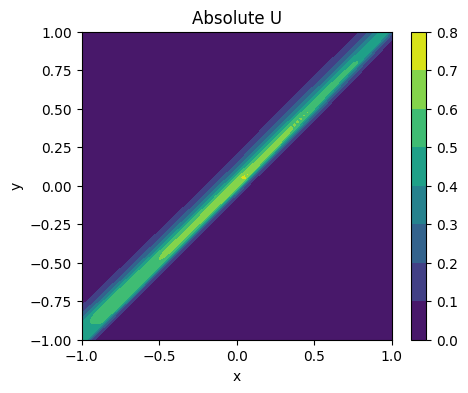

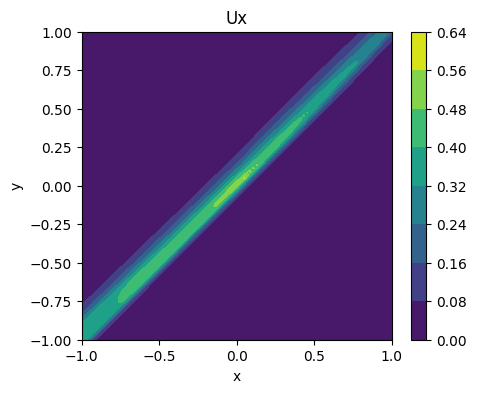

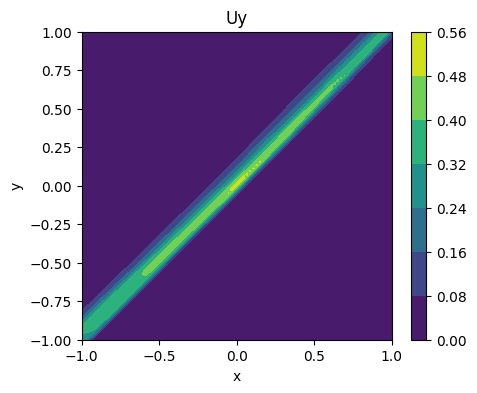

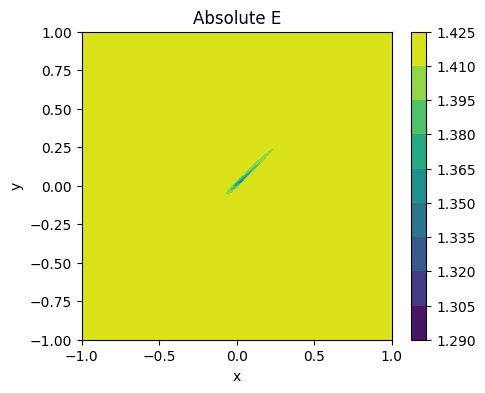

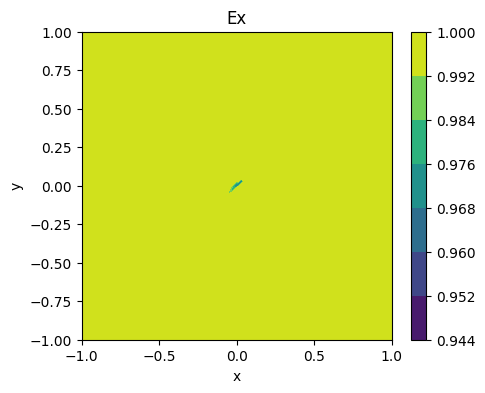

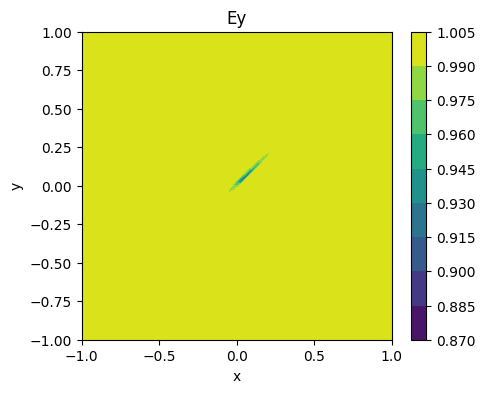

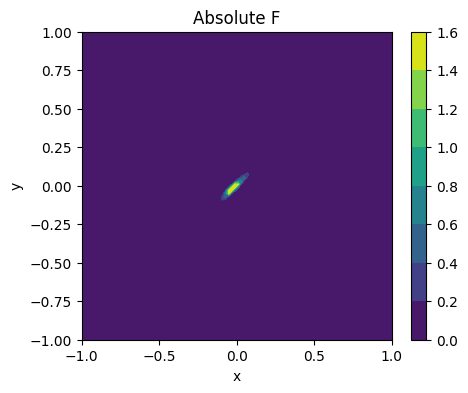

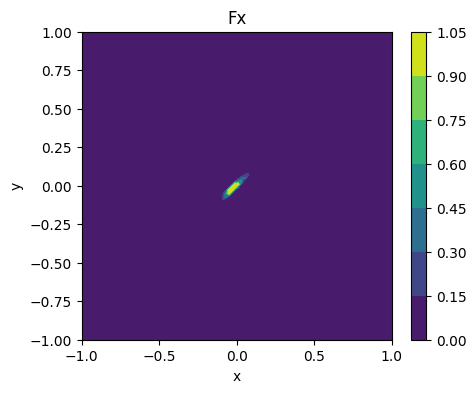

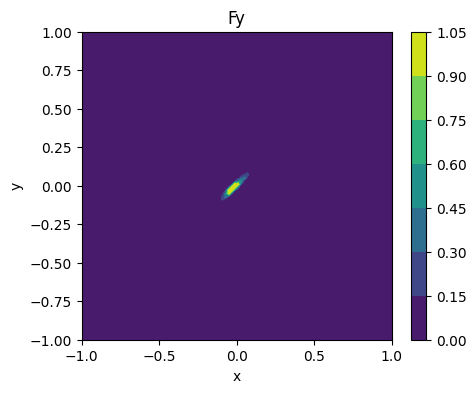

In [15]:
# 結果の可視化
def plot_solution(net, x, y):
    with torch.no_grad():
        net.eval().to(device)
        x = x.to(device)
        y = y.to(device)
        # ネットワークの出力を計算
        # 全組み合わせ[10000, 2]で、出力[10000, 6]を得る
        u = net(torch.cat((x, y), dim=1)).cpu().numpy()
        ux = u[:, 0]
        uy = u[:, 1]
        du = np.sqrt(ux**2 + uy**2)
        ex = u[:, 2]
        ey = u[:, 3]
        de = np.sqrt(ex**2 + ey**2)
        fx = u[:, 4]
        fy = u[:, 5]
        df = np.sqrt(fx**2 + fy**2)

        # x と t を 1D 配列に変換 ⇒ x= (10000,),t= (10000,)
        x = x.cpu().numpy().flatten()
        y = y.cpu().numpy().flatten()

        # メッシュグリッドの生成
        # 再度、[100, 100]にする、x,tをダブり抜きしてからmeshgrid
        # X, Y = np.meshgrid(np.unique(x), np.unique(y))
        X = x.reshape(100, 100)
        Y = y.reshape(100, 100)

        # u を 2D 配列に変換 [10000, 1]⇒[100, 100]
        UX = ux.reshape(len(np.unique(y)), len(np.unique(x)))
        UY = uy.reshape(len(np.unique(y)), len(np.unique(x)))
        DU = du.reshape(len(np.unique(y)), len(np.unique(x)))
        EX = ex.reshape(len(np.unique(y)), len(np.unique(x)))
        EY = ey.reshape(len(np.unique(y)), len(np.unique(x)))
        DE = de.reshape(len(np.unique(y)), len(np.unique(x)))
        FX = fx.reshape(len(np.unique(y)), len(np.unique(x)))
        FY = fy.reshape(len(np.unique(y)), len(np.unique(x)))
        DF = df.reshape(len(np.unique(y)), len(np.unique(x)))

        # print('X =', X[50,99])
        # print('Y =', Y[50,99])
        # print('FX=', FX[50,99])
        # print('FY=', FY[50,99])

        # プロット
        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, DU, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Absolute U')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, UX, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Ux')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, UY, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Uy')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, DE, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Absolute E')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, EX, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Ex')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, EY, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Ey')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, DF, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Absolute F')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, FX, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Fx')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, FY, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Fy')
        plt.show()

# x と t の範囲を設定
x_plot = torch.linspace(-L, L, 100).reshape(-1, 1) # [100, 1]
y_plot = torch.linspace(-L, L, 100).reshape(-1, 1) # [100, 1]

# メッシュグリッドを作成
# X_g は x_plot の値を列方向に繰り返した行列
# Y_g は y_plot の値を行方向に繰り返した行列
# X_g=[100, 100],Y_g=[100, 100]
X_g, Y_g = torch.meshgrid(x_plot.squeeze(), y_plot.squeeze(), indexing='ij')

# Flatten 行優先で1行目のあとに2行目を並べる
# cat dim=1 で全組み合わせ (n,2)
X_flat = X_g.reshape(-1, 1) # [10000, 1]
Y_flat = Y_g.reshape(-1, 1) # [10000, 1]

# 結果をプロット
plot_solution(model, X_flat, Y_flat)
